In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
bike_data = pd.read_csv('day.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
""" Since Dtedays and Instant variables may not be significant and hence, both the variables are being dropped"""
bike_data = bike_data.drop(['instant','dteday'],axis=1)
#bike_data = bike_data.drop('instant',axis=1)
bike_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


<Figure size 432x288 with 0 Axes>

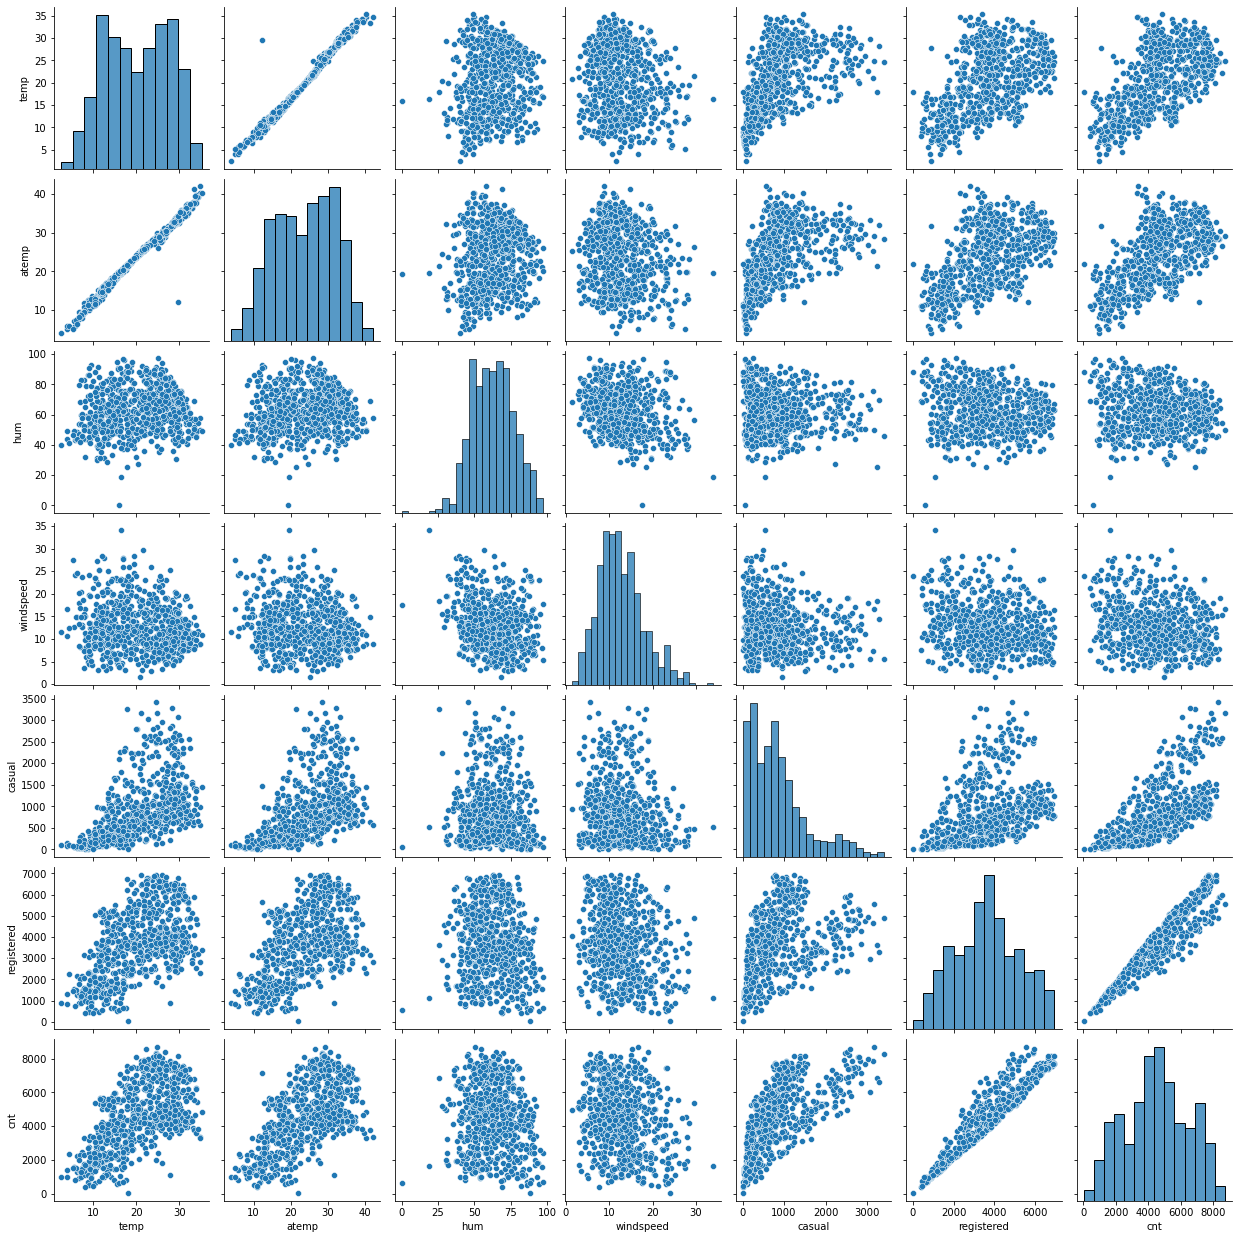

In [4]:
numeric_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
plt.figure()
sns.pairplot(bike_data, vars = numeric_vars)
plt.show()

From the above visuals, we can see that there is a positive linear relationship between the independent numeric variables 'Temp', 'Atemp' and the dependent variable 'Cnt'.
Though, the variables 'Casual' and 'Registered' also exhibit a linear relationship, it is important to understand that 'Cnt' is merely a sum total and hence introspection of this relationship is insignificant.

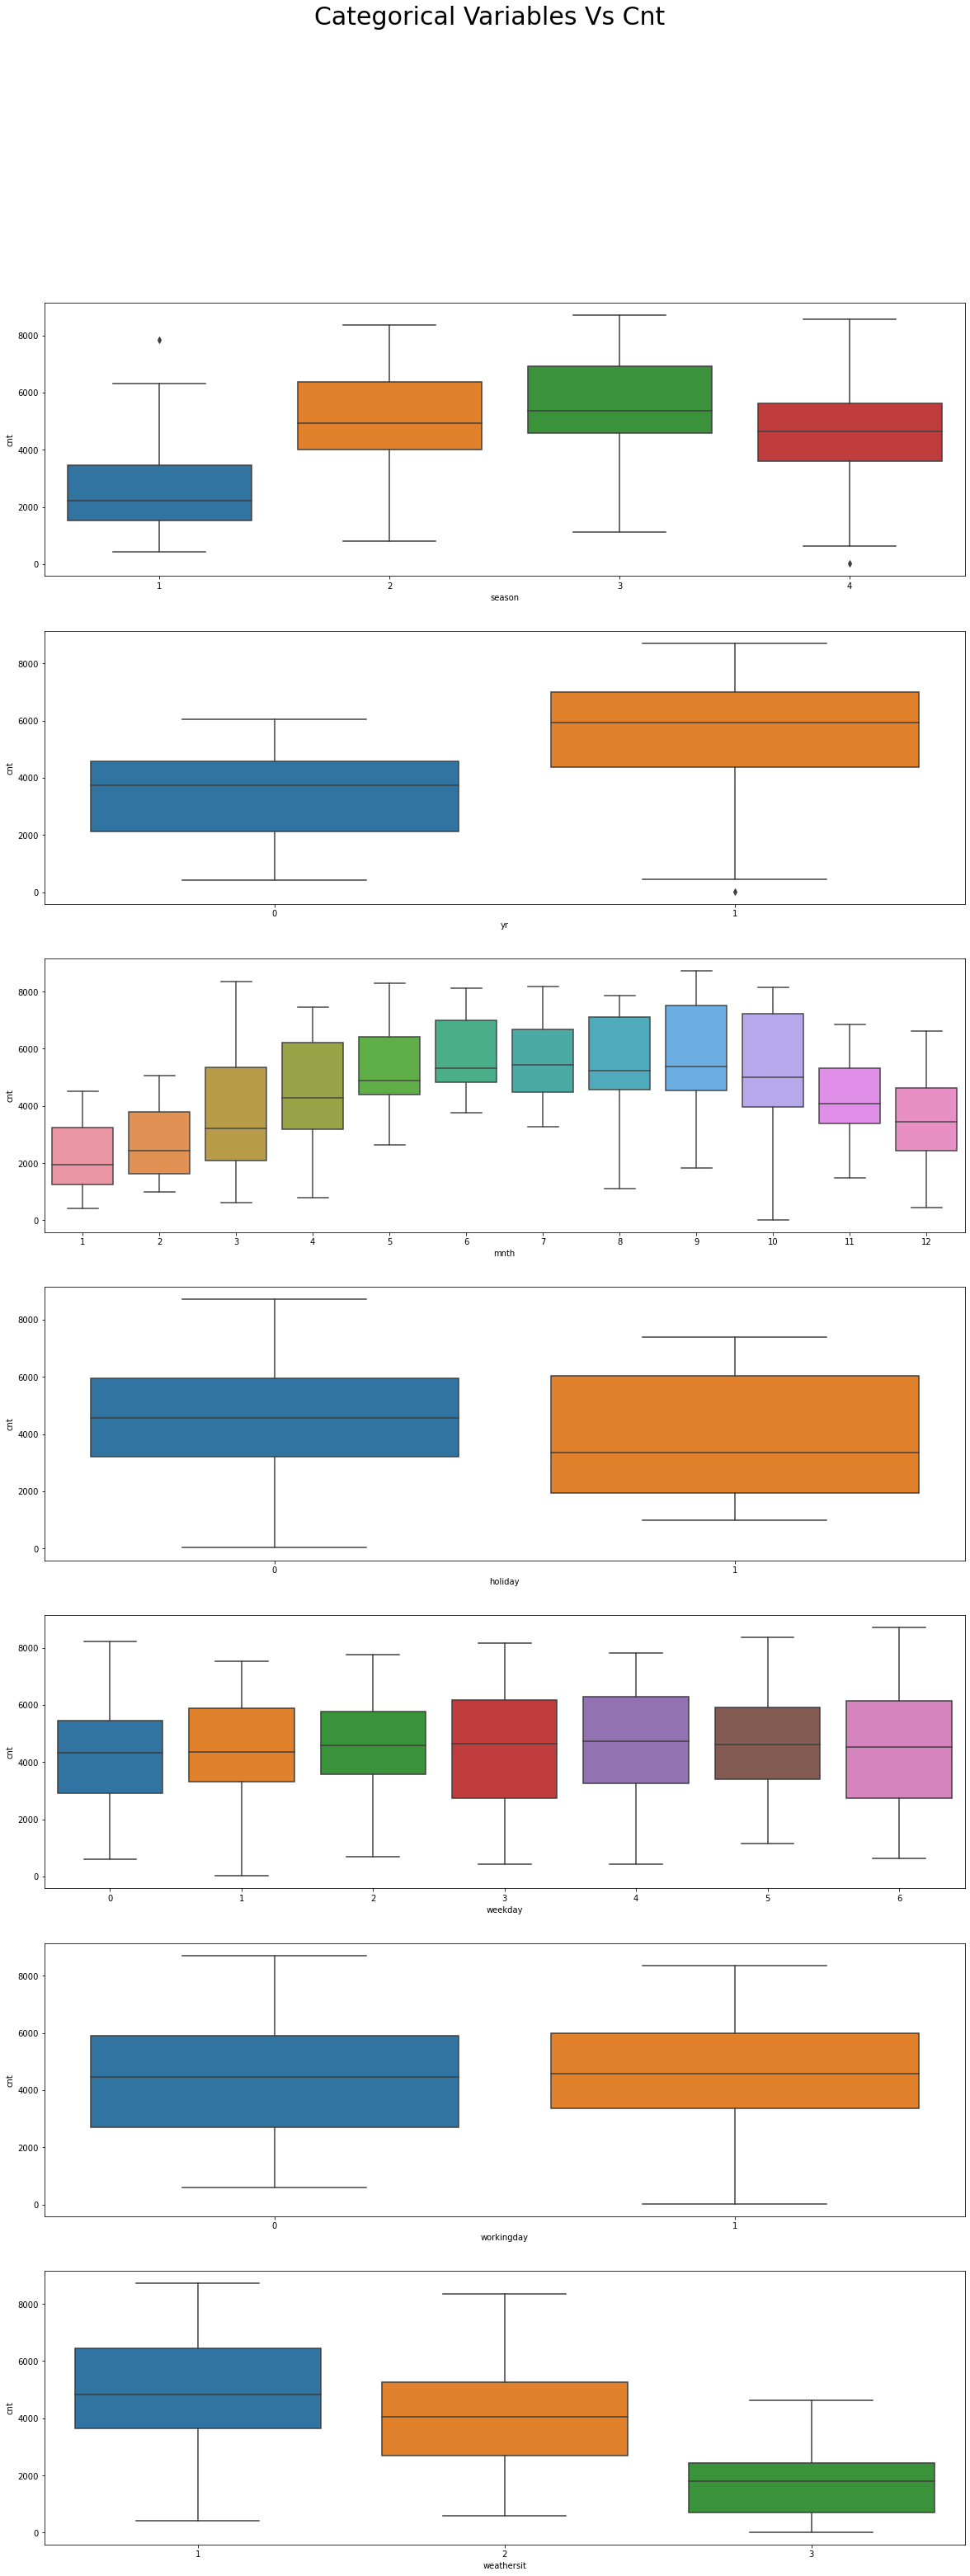

In [5]:
categorical_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

plt.figure(figsize = (20,50))
plt.suptitle('Categorical Variables Vs Cnt', fontsize=30)
plt.xlabel('xlabel', fontsize=30)
plt.ylabel('ylabel', fontsize=30)
j=0
for i in range(1,8):
    plt.subplot(7,1,i)
    sns.boxplot(x = categorical_vars[j], y = 'cnt', data = bike_data)
    j+=1

plt.show()

The following inferences can be drawn:-
    * Season 3 leads to significant increase in Bike Hires. Season 2 and 4 are average and Season 1 proves to be the least significant contributor.
    * The average bike rentals are significantly higher in the second year compared to the first year. The demand tends to increase over time.
    * The middle of the year, from April - October contribute to majority of bike rentals compared to the other months.
    * Weather situation 1 contributes to huge number of Bike rentals, with Situation 2 also contributing a significant sum. Weather situation 3 proves to be a time during which the demand is extremely less.

In [6]:
bike_data['season'] = 'Season' + bike_data['season'].astype(str)
bike_data['mnth'] = 'Month' + bike_data['mnth'].astype(str)
bike_data['weekday'] = 'Day' + bike_data['weekday'].astype(str)
bike_data['weathersit'] = 'Weather' + bike_data['weathersit'].astype(str)
bike_data.head(100)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Season1,0,Month1,0,Day6,0,Weather2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,Season1,0,Month1,0,Day0,0,Weather2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,Season1,0,Month1,0,Day1,1,Weather1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,Season1,0,Month1,0,Day2,1,Weather1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,Season1,0,Month1,0,Day3,1,Weather1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Season2,0,Month4,0,Day3,1,Weather1,16.024153,19.38040,47.0833,17.625221,413,2395,2808
96,Season2,0,Month4,0,Day4,1,Weather1,17.937500,21.68480,60.2917,10.874904,571,2570,3141
97,Season2,0,Month4,0,Day5,1,Weather2,13.769153,16.22395,83.6250,15.208464,172,1299,1471
98,Season2,0,Month4,0,Day6,0,Weather2,14.042500,17.07645,87.7500,8.916561,879,1576,2455


In [7]:
drop_columns = ['season','mnth','weekday','weathersit']

for col in drop_columns:
    dummy_var = pd.get_dummies(bike_data[col], drop_first= True)
    bike_data = pd.concat([bike_data,dummy_var], axis=1)
    bike_data.drop(col, axis=1, inplace=True)

bike_data.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Month8,Month9,Day1,Day2,Day3,Day4,Day5,Day6,Weather2,Weather3
0,0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,985,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,0,0,0,0,1,0,0,0,0,0


In [8]:
bike_data.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'Season2', 'Season3', 'Season4',
       'Month10', 'Month11', 'Month12', 'Month2', 'Month3', 'Month4', 'Month5',
       'Month6', 'Month7', 'Month8', 'Month9', 'Day1', 'Day2', 'Day3', 'Day4',
       'Day5', 'Day6', 'Weather2', 'Weather3'],
      dtype='object')

In [9]:
df_train, df_test = train_test_split(bike_data, train_size = 0.7, random_state = 100)
print(df_train.shape)
print(df_test.shape)

(510, 32)
(220, 32)


In [10]:
scaler = MinMaxScaler()
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Month8,Month9,Day1,Day2,Day3,Day4,Day5,Day6,Weather2,Weather3
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.294422,0.899220,0.827658,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.290765,0.446145,0.465255,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.110332,0.203869,0.204096,...,0,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.340750,0.444701,0.482973,...,0,0,0,0,0,0,0,1,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.053337,0.214554,0.191095,...,0,0,0,0,0,0,1,0,1,0


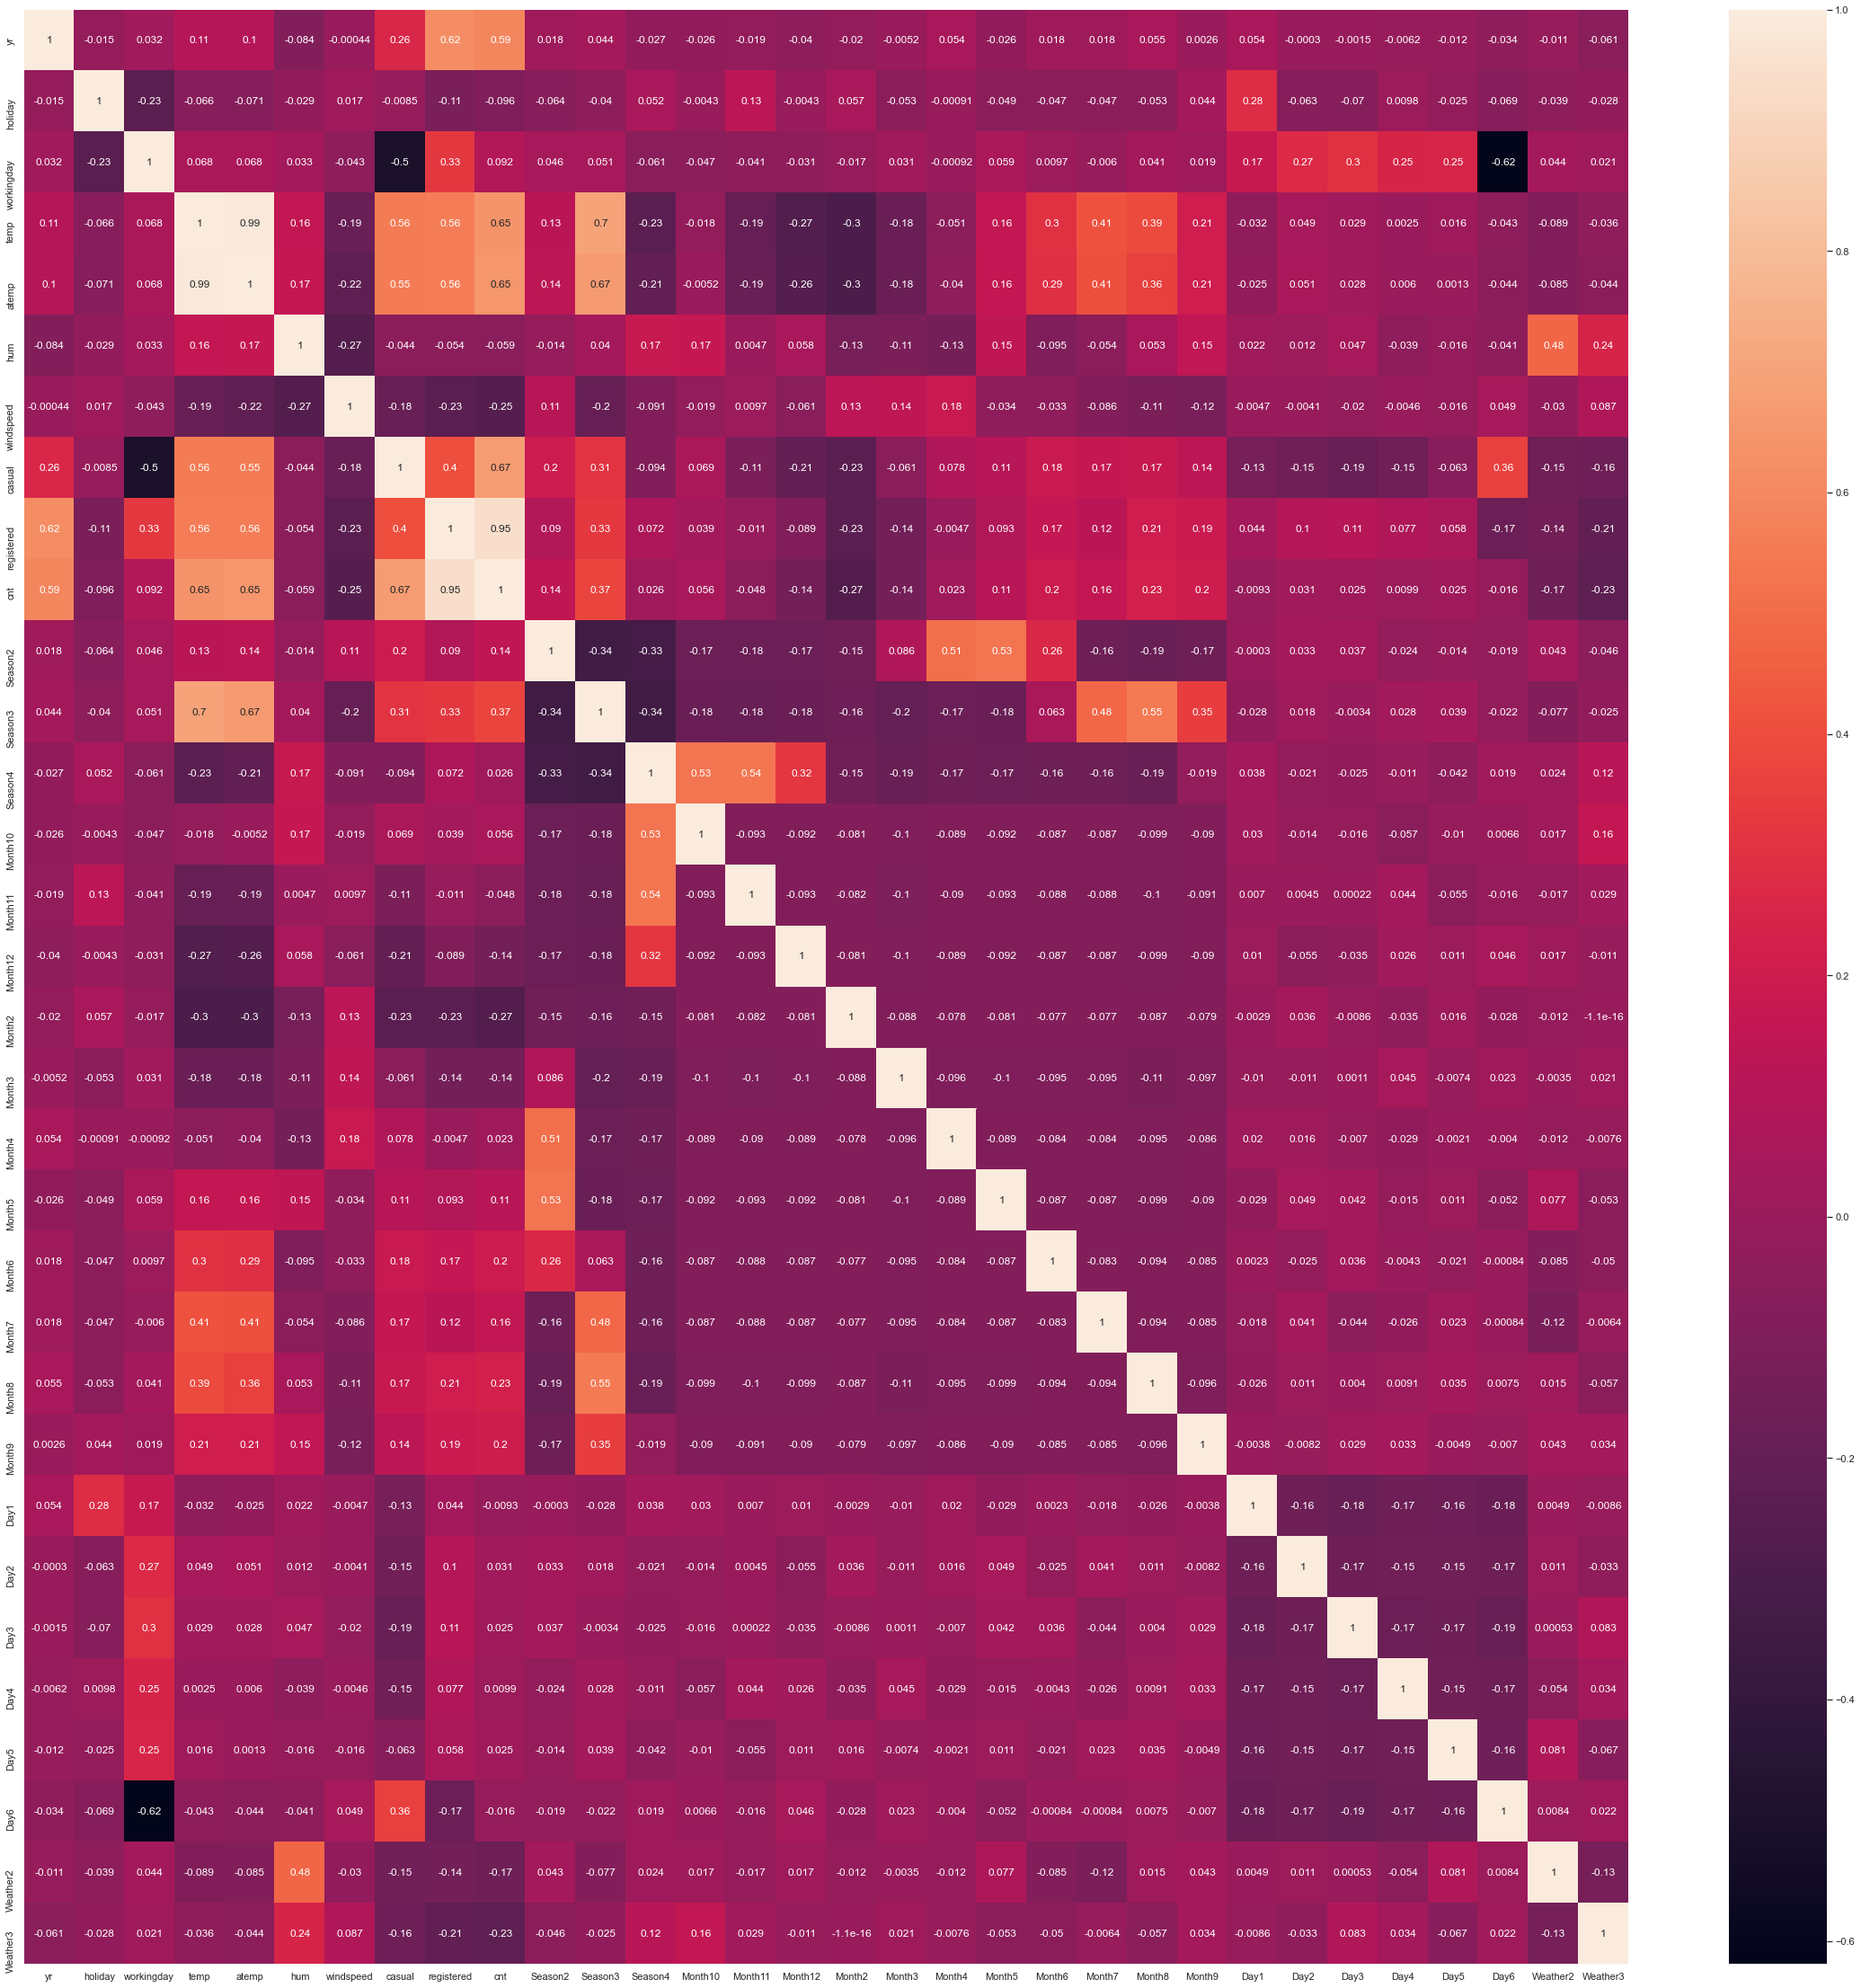

In [11]:
plt.figure(figsize=(40,40))
sns.set(font_scale=1)
sns.heatmap(df_train.corr(), annot = True)
plt.show()

In [12]:
y_train = df_train.pop('cnt')
X_train = df_train
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm,10)
rfe = rfe.fit(X_train, y_train)

In [13]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', False, 6),
 ('holiday', False, 22),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', False, 10),
 ('casual', True, 1),
 ('registered', True, 1),
 ('Season2', False, 8),
 ('Season3', True, 1),
 ('Season4', True, 1),
 ('Month10', False, 11),
 ('Month11', False, 12),
 ('Month12', True, 1),
 ('Month2', False, 13),
 ('Month3', False, 18),
 ('Month4', False, 9),
 ('Month5', False, 19),
 ('Month6', False, 2),
 ('Month7', True, 1),
 ('Month8', False, 4),
 ('Month9', False, 3),
 ('Day1', False, 20),
 ('Day2', False, 16),
 ('Day3', False, 15),
 ('Day4', False, 7),
 ('Day5', False, 5),
 ('Day6', False, 14),
 ('Weather2', False, 17),
 ('Weather3', False, 21)]

In [14]:
rfe_selected_columns = X_train.columns[rfe.support_]
rfe_selected_columns

Index(['workingday', 'temp', 'atemp', 'hum', 'casual', 'registered', 'Season3',
       'Season4', 'Month12', 'Month7'],
      dtype='object')

In [15]:
X_train_rfe = X_train[rfe_selected_columns]
X_train_rfe = sm.add_constant(X_train_rfe)

In [16]:
lm = sm.OLS(y_train, X_train_rfe)
lr_model = lm.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.875e+31
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:04:36   Log-Likelihood:                 17800.
No. Observations:                 510   AIC:                        -3.558e+04
Df Residuals:                     499   BIC:                        -3.553e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.064e-16   4.16e-17     -4.963      0.0

In [17]:
X_train_new = X_train_rfe.drop(['Season3'], axis = 1)
X_train_new.head()

,const,workingday,temp,atemp,hum,casual,registered,Season4,Month12,Month7
576,1.0,1,0.815169,0.766351,0.725633,0.294422,0.899220,0,0,1
426,1.0,0,0.442393,0.438975,0.640189,0.290765,0.446145,0,0,0
728,1.0,0,0.245101,0.200348,0.498067,0.110332,0.203869,0,1,0
482,1.0,0,0.395666,0.391735,0.504508,0.340750,0.444701,0,0,0
111,1.0,1,0.345824,0.318819,0.751824,0.053337,0.214554,0,0,0


In [18]:
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.228e+31
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:04:49   Log-Likelihood:                 17584.
No. Observations:                 510   AIC:                        -3.515e+04
Df Residuals:                     500   BIC:                        -3.511e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.671e-16   6.26e-17     -4.270      0.0

In [19]:
X_train_new = X_train_new.drop(['atemp'], axis = 1)
X_train_new.head()

,const,workingday,temp,hum,casual,registered,Season4,Month12,Month7
576,1.0,1,0.815169,0.725633,0.294422,0.899220,0,0,1
426,1.0,0,0.442393,0.640189,0.290765,0.446145,0,0,0
728,1.0,0,0.245101,0.498067,0.110332,0.203869,0,1,0
482,1.0,0,0.395666,0.504508,0.340750,0.444701,0,0,0
111,1.0,1,0.345824,0.751824,0.053337,0.214554,0,0,0


In [20]:
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.389e+31
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:04:58   Log-Likelihood:                 17270.
No. Observations:                 510   AIC:                        -3.452e+04
Df Residuals:                     501   BIC:                        -3.448e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.238e-16   1.16e-16     -1.935      0.0

In [21]:
X_train_new = X_train_new.drop(['temp'], axis = 1)
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.814e+31
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:05:01   Log-Likelihood:                 17415.
No. Observations:                 510   AIC:                        -3.481e+04
Df Residuals:                     502   BIC:                        -3.478e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.388e-17   8.68e-17     -0.160      0.8

In [22]:
X_train_new = X_train_new.drop(['const'], axis = 1)
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.049e+32
Date:                Wed, 19 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:05:04   Log-Likelihood:                          17555.
No. Observations:                 510   AIC:                                 -3.510e+04
Df Residuals:                     503   BIC:                                 -3.507e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
X_train_new = X_train_new.drop(['Month7'], axis = 1)
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.433e+32
Date:                Wed, 19 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:05:08   Log-Likelihood:                          17323.
No. Observations:                 510   AIC:                                 -3.463e+04
Df Residuals:                     504   BIC:                                 -3.461e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

     Features    VIF
3  registered  14.85
0  workingday   8.01
1         hum   7.28
2      casual   7.16
4     Season4   1.65
5     Month12   1.27


In [25]:
X_train_new = X_train_new.drop(['registered'], axis = 1)
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              2173.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:05:22   Log-Likelihood:                          365.85
No. Observations:                 510   AIC:                                     -721.7
Df Residuals:                     505   BIC:                                     -700.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
X_train_new = X_train_new.drop(['hum'], axis = 1)
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              2720.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:05:25   Log-Likelihood:                          365.71
No. Observations:                 510   AIC:                                     -723.4
Df Residuals:                     506   BIC:                                     -706.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
X_train_new = X_train_new.drop(['Month12'], axis = 1)
lm = sm.OLS(y_train, X_train_new)
lr_model = lm.fit()
print(lr_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              3612.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:05:27   Log-Likelihood:                          364.24
No. Observations:                 510   AIC:                                     -722.5
Df Residuals:                     507   BIC:                                     -709.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [28]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

     Features   VIF
0  workingday  1.37
1      casual  1.32
2     Season4  1.21


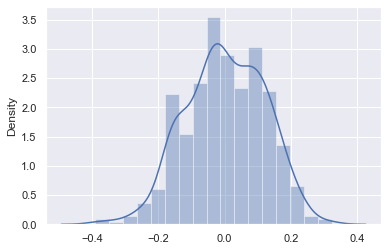

In [29]:
y_train_pred = lr_model.predict(X_train_new)

res = y_train - y_train_pred

plt.figure()
sns.distplot(res)
plt.show()

In [30]:
df_test[numeric_vars] = scaler.transform(df_test[numeric_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Month8,Month9,Day1,Day2,Day3,Day4,Day5,Day6,Weather2,Weather3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.933557,0.427086,0.692706,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.265163,0.767976,0.712034,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.072539,0.346376,0.303382,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.268820,0.559630,0.547400,...,1,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.223712,0.608143,0.569029,...,0,0,0,0,0,1,0,0,0,0


In [31]:
y_test = df_test.pop('cnt')
X_test = df_test[['workingday','casual','Season4']]

In [32]:
y_pred_test = lr_model.predict(X_test)

In [33]:
rsquare = r2_score(y_test, y_pred_test)
print(rsquare)

0.6667643745612928
